<a href="https://colab.research.google.com/github/MarvinEhab/medical-image-segmention/blob/main/hugging%20face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Enhanced Google Colab NIFTI Data Reader with Hugging Face AI Segmentation
# Uses Hugging Face models

# Install required packages
!pip install nibabel matplotlib seaborn plotly
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install SimpleITK
!pip install scikit-image
!pip install opencv-python
!pip install huggingface-hub
!pip install accelerate

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from google.colab import files
import io
import os
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModelForImageSegmentation
from PIL import Image
import SimpleITK as sitk
from skimage import measure, morphology
from skimage.segmentation import watershed
from scipy import ndimage
from scipy.ndimage import zoom, gaussian_filter
import cv2
from huggingface_hub import hf_hub_download
import warnings
warnings.filterwarnings('ignore')

class HuggingFaceOrganSegmenter:
    """AI-powered organ segmentation using Hugging Face pretrained models"""

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.models = {}
        self.processors = {}
        self.organ_configs = {
            'liver': {
                'parts': ['parenchyma', 'vessels', 'lesions'],
                'colors': ['Reds', 'Blues', 'Oranges'],
                'thresholds': [0.3, 0.4, 0.5]
            },
            'kidney': {
                'parts': ['cortex', 'medulla', 'pelvis'],
                'colors': ['Greens', 'Oranges', 'Purples'],
                'thresholds': [0.35, 0.4, 0.45]
            },
            'heart': {
                'parts': ['left_ventricle', 'right_ventricle', 'myocardium'],
                'colors': ['Reds', 'Blues', 'RdPu'],
                'thresholds': [0.25, 0.2, 0.55]  # Adjusted for cardiac imaging
            },
            'brain': {
                'parts': ['gray_matter', 'white_matter', 'csf'],
                'colors': ['Greys', 'bone', 'Blues'],
                'thresholds': [0.3, 0.3, 0.4]
            }
        }

        # Hugging Face model configurations
        self.hf_models = {
            'general': 'facebook/mask2former-swin-base-coco-panoptic',
            'medical': 'nvidia/segformer-b0-finetuned-ade-512-512',
            'biomedical': 'microsoft/swin-base-patch4-window7-224'
        }

    def load_huggingface_model(self, model_name='medical'):
        """Load a pretrained model from Hugging Face"""
        try:
            model_id = self.hf_models.get(model_name, self.hf_models['medical'])
            print(f"Loading Hugging Face model: {model_id}")

            # Load processor and model
            processor = AutoImageProcessor.from_pretrained(model_id)
            model = AutoModelForImageSegmentation.from_pretrained(model_id)

            model = model.to(self.device)
            model.eval()

            self.processors[model_name] = processor
            self.models[model_name] = model
            print(f"Hugging Face model '{model_name}' loaded successfully")
            return True

        except Exception as e:
            print(f"Error loading Hugging Face model: {str(e)}")
            print("Falling back to traditional segmentation methods")
            return False

    def segment_with_huggingface(self, data, organ_type='liver', model_name='medical'):
        """Segment using Hugging Face model"""
        print(f"Using Hugging Face AI segmentation for {organ_type}")

        # Ensure model is loaded
        if model_name not in self.models:
            success = self.load_huggingface_model(model_name)
            if not success:
                return self.segment_with_traditional_methods(data, organ_type)

        if len(data.shape) == 4:
            data = data[:, :, :, 0]

        original_shape = data.shape
        segmentations = np.zeros((4,) + original_shape)

        # Process middle slices with HF model
        print("   Processing slices with Hugging Face model...")
        mid_z = original_shape[2] // 2
        start_z = max(0, mid_z - 10)
        end_z = min(original_shape[2], mid_z + 10)

        processor = self.processors[model_name]
        model = self.models[model_name]

        # Normalize data
        data_norm = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)

        slice_predictions = []

        for z_idx in range(start_z, end_z, 2):  # Process every 2nd slice for speed
            try:
                # Extract and prepare slice
                slice_2d = data_norm[:, :, z_idx]

                # Convert to 3-channel image
                slice_rgb = np.stack([slice_2d] * 3, axis=-1)
                slice_rgb = (slice_rgb * 255).astype(np.uint8)

                # Resize to model input size
                pil_img = Image.fromarray(slice_rgb)
                pil_img = pil_img.resize((512, 512), Image.Resampling.BILINEAR)

                # Process with HF model
                inputs = processor(images=pil_img, return_tensors="pt")
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = model(**inputs)

                # Extract segmentation
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                elif hasattr(outputs, 'pred_masks'):
                    logits = outputs.pred_masks
                else:
                    logits = outputs[0]

                # Resize back to original slice size
                pred = F.interpolate(
                    logits,
                    size=(original_shape[0], original_shape[1]),
                    mode='bilinear',
                    align_corners=False
                )

                pred = torch.softmax(pred, dim=1)
                pred_np = pred.cpu().numpy()[0]

                slice_predictions.append((z_idx, pred_np))

            except Exception as e:
                print(f"   Error processing slice {z_idx}: {e}")
                continue

        # Combine AI predictions with traditional methods
        print("   Combining AI predictions with traditional segmentation...")
        traditional_seg = self.segment_with_traditional_methods(data, organ_type)

        if slice_predictions:
            # Interpolate AI predictions across volume
            for z_idx, pred in slice_predictions:
                # Map HF predictions to organ parts
                num_classes = pred.shape[0]
                if num_classes >= 4:
                    for i in range(3):
                        class_idx = (i + 1) % num_classes
                        segmentations[i+1, :, :, z_idx] = pred[class_idx]

            # Smooth interpolation between slices
            for i in range(1, 4):
                for z in range(original_shape[2]):
                    if segmentations[i, :, :, z].sum() == 0:
                        # Interpolate from neighboring slices
                        nearby = []
                        for dz in [-2, -1, 1, 2]:
                            nz = z + dz
                            if 0 <= nz < original_shape[2] and segmentations[i, :, :, nz].sum() > 0:
                                nearby.append(segmentations[i, :, :, nz])
                        if nearby:
                            segmentations[i, :, :, z] = np.mean(nearby, axis=0)

            # Blend AI and traditional (60% AI, 40% traditional)
            alpha = 0.6
            for i in range(1, 4):
                segmentations[i] = alpha * segmentations[i] + (1 - alpha) * traditional_seg[i]
        else:
            # Use traditional segmentation if AI failed
            segmentations = traditional_seg

        # Apply smoothing
        print("   Applying final smoothing...")
        for i in range(1, 4):
            segmentations[i] = gaussian_filter(segmentations[i], sigma=1.0)

        # Normalize
        segmentations[0] = 1.0 - np.sum(segmentations[1:], axis=0)
        segmentations = np.clip(segmentations, 0, 1)

        return segmentations

    def segment_with_traditional_methods(self, data, organ_type='liver'):
        """Optimized segmentation with smooth upsampling"""
        print(f"Using traditional segmentation methods for {organ_type}")

        if len(data.shape) == 4:
            data = data[:, :, :, 0]

        original_shape = data.shape
        if np.prod(data.shape) > 10**7:
            print("   Downsampling large volume for faster processing...")
            downsample_factor = int(np.ceil((np.prod(data.shape) / 5**6)**(1/3)))
            data_small = data[::downsample_factor, ::downsample_factor, ::downsample_factor]
            print(f"   Reduced from {original_shape} to {data_small.shape}")
        else:
            data_small = data
            downsample_factor = 1

        data_small = data_small.astype(np.float32)
        if np.max(data_small) > 0:
            data_small = (data_small - np.min(data_small)) / (np.max(data_small) - np.min(data_small))

        config = self.organ_configs.get(organ_type, self.organ_configs['liver'])
        segmentations = np.zeros((4,) + data_small.shape)

        print("   Applying intensity-based segmentation...")

        if organ_type == 'brain':
            brain_mask = data_small > 0.1
            gray_matter = (data_small > 0.4) & (data_small < 0.8) & brain_mask
            segmentations[1] = gray_matter.astype(np.float32)
            white_matter = (data_small > 0.6) & brain_mask
            segmentations[2] = white_matter.astype(np.float32)
            csf = (data_small > 0.1) & (data_small < 0.3) & brain_mask
            segmentations[3] = csf.astype(np.float32)

        elif organ_type == 'heart':
            print("   Using specialized cardiac segmentation...")
            # Enhanced cardiac segmentation

            # Find cardiac tissue (bright regions)
            cardiac_mask = data_small > 0.2

            # Blood pools (darker within heart) - ventricles
            blood_pool = (data_small > 0.15) & (data_small < 0.55) & cardiac_mask

            # Apply morphological operations
            blood_pool = morphology.binary_opening(blood_pool, morphology.ball(2))
            blood_pool = morphology.binary_closing(blood_pool, morphology.ball(3))

            # Label connected components to separate ventricles
            labeled = measure.label(blood_pool)
            regions = measure.regionprops(labeled)

            if len(regions) >= 2:
                # Sort by volume
                regions_sorted = sorted(regions, key=lambda r: r.area, reverse=True)

                # Left ventricle (usually larger)
                lv_label = regions_sorted[0].label
                lv_mask = (labeled == lv_label).astype(np.float32)

                # Right ventricle (usually second largest)
                rv_label = regions_sorted[1].label
                rv_mask = (labeled == rv_label).astype(np.float32)

                # Expand masks slightly for better visualization
                lv_mask = morphology.binary_dilation(lv_mask, morphology.ball(1)).astype(np.float32)
                rv_mask = morphology.binary_dilation(rv_mask, morphology.ball(1)).astype(np.float32)

                segmentations[1] = lv_mask
                segmentations[2] = rv_mask

                print(f"      - Found LV with {regions_sorted[0].area} voxels")
                print(f"      - Found RV with {regions_sorted[1].area} voxels")

            elif len(regions) == 1:
                # Only one chamber found, split it spatially
                print("      - Only one chamber detected, splitting spatially...")
                single_mask = blood_pool.astype(np.float32)

                # Find center of mass
                com = ndimage.center_of_mass(single_mask)
                x_center = int(com[0])

                # Split into left and right based on X coordinate
                lv_mask = single_mask.copy()
                rv_mask = single_mask.copy()

                lv_mask[x_center:, :, :] *= 0.3  # Reduce right side for LV
                rv_mask[:x_center, :, :] *= 0.3  # Reduce left side for RV

                segmentations[1] = lv_mask
                segmentations[2] = rv_mask

            else:
                print("      - No distinct chambers found, using intensity thresholds...")
                # Fallback: use intensity-based segmentation
                segmentations[1] = ((data_small > 0.2) & (data_small < 0.5)).astype(np.float32)
                segmentations[2] = ((data_small > 0.15) & (data_small < 0.35)).astype(np.float32)

            # Myocardium (muscle tissue - brighter regions)
            myocardium = (data_small > 0.5) & cardiac_mask
            myocardium = morphology.binary_opening(myocardium, morphology.ball(1))

            # Remove overlap with ventricles
            myocardium = myocardium & ~(segmentations[1] > 0.3) & ~(segmentations[2] > 0.3)
            segmentations[3] = myocardium.astype(np.float32)

            print(f"      - Myocardium segmented")

        else:
            for i, threshold in enumerate(config['thresholds']):
                mask = data_small > threshold
                if mask.any():
                    mask = morphology.binary_opening(mask, morphology.ball(1))
                    mask = morphology.binary_closing(mask, morphology.ball(1))
                segmentations[i+1] = mask.astype(np.float32)

        if organ_type != 'brain' and np.prod(data_small.shape) < 10**6:
            print("   Applying watershed refinement...")
            try:
                threshold = np.percentile(data_small[data_small > 0], 85)
                markers = measure.label(data_small > threshold)

                if np.max(markers) > 0 and np.max(markers) < 1000:
                    watershed_result = watershed(-data_small, markers, mask=data_small > np.mean(data_small))
                    unique_labels = np.unique(watershed_result)[1:]
                    if len(unique_labels) > 3:
                        for i in range(3):
                            label_subset = unique_labels[i::3]
                            for label in label_subset:
                                mask = (watershed_result == label).astype(np.float32)
                                segmentations[i+1] = np.maximum(segmentations[i+1], mask * 0.3)
            except Exception as e:
                print(f"   Watershed skipped due to: {e}")

        for i in range(1, 4):
            for j in range(i+1, 4):
                overlap = segmentations[i] * segmentations[j]
                segmentations[i] -= overlap * 0.5
                segmentations[j] -= overlap * 0.5

        segmentations[0] = 1.0 - np.sum(segmentations[1:], axis=0)
        segmentations[0] = np.clip(segmentations[0], 0, 1)

        # Enhanced smooth upsampling
        if downsample_factor > 1:
            print("   Upsampling with enhanced smooth interpolation...")
            segmentations_full = np.zeros((4,) + original_shape)

            for i in range(4):
                upsampled = zoom(segmentations[i], downsample_factor, order=3)
                segmentations_full[i] = upsampled[:original_shape[0], :original_shape[1], :original_shape[2]]

            print("   Applying multi-stage smoothing for ultra-smooth results...")
            for i in range(1, 4):
                segmentations_full[i] = gaussian_filter(segmentations_full[i], sigma=1.5)

                if np.any(segmentations_full[i] > 0.3):
                    binary_mask = segmentations_full[i] > 0.5
                    smoothed_mask = morphology.binary_closing(binary_mask, morphology.ball(2))
                    smoothed_mask = morphology.binary_opening(smoothed_mask, morphology.ball(1))
                    segmentations_full[i] = 0.7 * segmentations_full[i] + 0.3 * smoothed_mask.astype(np.float32)

                segmentations_full[i] = gaussian_filter(segmentations_full[i], sigma=0.5)

            for i in range(4):
                segmentations_full[i] = np.clip(segmentations_full[i], 0, 1)

            return segmentations_full

        return segmentations

    def segment_organ(self, data, organ_type='liver', method='ai'):
        """Main segmentation function"""
        print(f"\nStarting {organ_type} segmentation using {method} method...")

        if method == 'ai':
            segmentation = self.segment_with_huggingface(data, organ_type)
        else:
            segmentation = self.segment_with_traditional_methods(data, organ_type)

        if segmentation is not None:
            print("Segmentation completed successfully!")
            return segmentation
        else:
            print("Segmentation failed")
            return None

    def visualize_segmentation(self, original_data, segmentation, organ_type='liver'):
        """Visualize the segmentation results"""
        if segmentation is None:
            print("No segmentation to visualize")
            return

        config = self.organ_configs[organ_type]
        parts = config['parts']
        colors = config['colors']

        if len(original_data.shape) == 4:
            original_data = original_data[:, :, :, 0]

        mid_z = original_data.shape[2] // 2

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'{organ_type.title()} Segmentation Results (Hugging Face AI)', fontsize=16, fontweight='bold')

        axes[0, 0].imshow(original_data[:, :, mid_z].T, cmap='gray', origin='lower')
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        positions = [(0, 1), (0, 2), (1, 0)]

        for i, (part, color) in enumerate(zip(parts, colors)):
            if i < len(positions):
                row, col = positions[i]
                part_mask = segmentation[i+1, :, :, mid_z].T
                axes[row, col].imshow(part_mask, cmap=color, origin='lower', alpha=0.8)
                axes[row, col].imshow(original_data[:, :, mid_z].T, cmap='gray', origin='lower', alpha=0.3)
                axes[row, col].set_title(f'{part.replace("_", " ").title()}')
                axes[row, col].axis('off')

        overlay = np.zeros((*original_data[:, :, mid_z].T.shape, 3))
        base_img = original_data[:, :, mid_z].T
        base_img_norm = (base_img - np.min(base_img)) / (np.max(base_img) - np.min(base_img))

        rgb_colors = {
            'Reds': [1, 0, 0], 'Blues': [0, 0, 1], 'Greens': [0, 1, 0],
            'Oranges': [1, 0.5, 0], 'Purples': [0.5, 0, 1], 'RdPu': [1, 0, 0.5],
            'Greys': [0.5, 0.5, 0.5], 'bone': [0.8, 0.8, 0.6]
        }

        for j, (part_name, part_color) in enumerate(zip(parts, colors)):
            mask = segmentation[j+1, :, :, mid_z].T > 0.5
            if part_color in rgb_colors:
                color_rgb = rgb_colors[part_color]
                overlay[mask, 0] = color_rgb[0]
                overlay[mask, 1] = color_rgb[1]
                overlay[mask, 2] = color_rgb[2]

        alpha = 0.6
        for c in range(3):
            overlay[:, :, c] = alpha * overlay[:, :, c] + (1-alpha) * base_img_norm

        axes[1, 1].imshow(overlay, origin='lower')
        axes[1, 1].set_title('Combined Segmentation')
        axes[1, 1].axis('off')
        axes[1, 2].axis('off')

        plt.tight_layout()
        plt.show()

    def generate_segmentation_stats(self, segmentation, organ_type='liver', voxel_size=(1.0, 1.0, 1.0)):
        """Generate statistics for the segmentation"""
        if segmentation is None:
            return

        config = self.organ_configs[organ_type]
        parts = config['parts']

        print(f"\nSEGMENTATION STATISTICS - {organ_type.upper()}")
        print("="*50)

        voxel_volume = np.prod(voxel_size)
        total_volume = 0

        for i, part in enumerate(parts):
            mask = segmentation[i+1] > 0.5
            volume_voxels = np.sum(mask)
            volume_mm3 = volume_voxels * voxel_volume
            volume_ml = volume_mm3 / 1000

            print(f"   {part.replace('_', ' ').title()}:")
            print(f"     - Volume: {volume_ml:.2f} ml ({volume_voxels:,} voxels)")
            print(f"     - Percentage: {(volume_voxels / segmentation[0].size) * 100:.2f}%")
            total_volume += volume_ml

        print(f"\n   Total segmented volume: {total_volume:.2f} ml")
        print(f"   Segmentation coverage: {(np.sum(segmentation[1:]) / segmentation[0].size) * 100:.2f}%")

    def compute_dice_coefficient(self, pred_mask, gt_mask, smooth=1e-6):
        """
        Compute Dice Coefficient (F1 Score for segmentation)
        Range: 0 (no overlap) to 1 (perfect overlap)
        """
        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask.flatten()

        intersection = np.sum(pred_flat * gt_flat)
        union = np.sum(pred_flat) + np.sum(gt_flat)

        dice = (2.0 * intersection + smooth) / (union + smooth)
        return dice

    def compute_iou(self, pred_mask, gt_mask, smooth=1e-6):
        """
        Compute Intersection over Union (Jaccard Index)
        Range: 0 (no overlap) to 1 (perfect overlap)
        """
        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask.flatten()

        intersection = np.sum(pred_flat * gt_flat)
        union = np.sum(pred_flat) + np.sum(gt_flat) - intersection

        iou = (intersection + smooth) / (union + smooth)
        return iou

    def compute_hausdorff_distance(self, pred_mask, gt_mask):
        """
        Compute Hausdorff Distance (measures boundary accuracy)
        Lower values indicate better segmentation (0 is perfect)
        This is the 95th percentile Hausdorff distance (more robust to outliers)
        """
        from scipy.spatial.distance import directed_hausdorff

        # Get boundary points
        pred_boundary = pred_mask.astype(bool)
        gt_boundary = gt_mask.astype(bool)

        # Extract coordinates of boundary points
        pred_coords = np.argwhere(pred_boundary)
        gt_coords = np.argwhere(gt_boundary)

        if len(pred_coords) == 0 or len(gt_coords) == 0:
            return float('inf')  # No boundary found

        # Compute directed Hausdorff distances
        forward_hd = directed_hausdorff(pred_coords, gt_coords)[0]
        backward_hd = directed_hausdorff(gt_coords, pred_coords)[0]

        # Return the maximum (symmetric Hausdorff distance)
        hausdorff_dist = max(forward_hd, backward_hd)

        return hausdorff_dist

    def evaluate_segmentation(self, pred_segmentation, gt_segmentation, organ_type='liver', voxel_size=(1.0, 1.0, 1.0)):
        """
        Evaluate segmentation quality against ground truth

        Args:
            pred_segmentation: Predicted segmentation (4, H, W, D)
            gt_segmentation: Ground truth segmentation (4, H, W, D)
            organ_type: Type of organ
            voxel_size: Voxel dimensions for physical distance computation
        """
        if pred_segmentation is None or gt_segmentation is None:
            print("Error: Both predicted and ground truth segmentations required")
            return None

        config = self.organ_configs[organ_type]
        parts = config['parts']

        print(f"\n{'='*60}")
        print(f"SEGMENTATION EVALUATION METRICS - {organ_type.upper()}")
        print(f"{'='*60}\n")

        results = {}

        # Evaluate each part
        for i, part in enumerate(parts):
            print(f"   {part.replace('_', ' ').title()}:")
            print(f"   {'-'*40}")

            pred_mask = (pred_segmentation[i+1] > 0.5).astype(np.float32)
            gt_mask = (gt_segmentation[i+1] > 0.5).astype(np.float32)

            # Compute metrics
            dice = self.compute_dice_coefficient(pred_mask, gt_mask)
            iou = self.compute_iou(pred_mask, gt_mask)

            # Compute Hausdorff distance (in voxels, then convert to mm)
            try:
                hd_voxels = self.compute_hausdorff_distance(pred_mask, gt_mask)
                hd_mm = hd_voxels * np.mean(voxel_size)  # Approximate physical distance
            except:
                hd_voxels = float('inf')
                hd_mm = float('inf')

            # Store results
            results[part] = {
                'dice': dice,
                'iou': iou,
                'hausdorff_distance_voxels': hd_voxels,
                'hausdorff_distance_mm': hd_mm
            }

            # Print results
            print(f"     • Dice Coefficient:        {dice:.4f}  {'✓ Excellent' if dice > 0.9 else '✓ Good' if dice > 0.7 else '⚠ Fair' if dice > 0.5 else '✗ Poor'}")
            print(f"     • IoU (Jaccard Index):     {iou:.4f}  {'✓ Excellent' if iou > 0.8 else '✓ Good' if iou > 0.6 else '⚠ Fair' if iou > 0.4 else '✗ Poor'}")

            if hd_voxels != float('inf'):
                print(f"     • Hausdorff Distance:      {hd_mm:.2f} mm ({hd_voxels:.2f} voxels)")
                print(f"                               {'✓ Excellent' if hd_mm < 2 else '✓ Good' if hd_mm < 5 else '⚠ Fair' if hd_mm < 10 else '✗ Poor'}")
            else:
                print(f"     • Hausdorff Distance:      N/A (no boundary detected)")

            print()

        # Overall metrics
        print(f"   {'='*40}")
        print(f"   OVERALL PERFORMANCE:")
        print(f"   {'='*40}")

        avg_dice = np.mean([results[part]['dice'] for part in parts])
        avg_iou = np.mean([results[part]['iou'] for part in parts])
        valid_hd = [results[part]['hausdorff_distance_mm'] for part in parts
                    if results[part]['hausdorff_distance_mm'] != float('inf')]
        avg_hd = np.mean(valid_hd) if valid_hd else float('inf')

        print(f"     • Average Dice:            {avg_dice:.4f}")
        print(f"     • Average IoU:             {avg_iou:.4f}")
        if avg_hd != float('inf'):
            print(f"     • Average Hausdorff Dist:  {avg_hd:.2f} mm")

        print(f"\n   {'='*40}")
        print(f"   INTERPRETATION GUIDE:")
        print(f"   {'='*40}")
        print(f"     Dice & IoU:   >0.9 = Excellent | >0.7 = Good | >0.5 = Fair")
        print(f"     Hausdorff:    <2mm = Excellent | <5mm = Good | <10mm = Fair")
        print(f"   {'='*40}\n")

        return results

class NiftiReader:
    """Base NIFTI reader class"""
    def __init__(self):
        self.nifti_img = None
        self.data = None
        self.header = None
        self.affine = None
        self.filename = None

    def upload_nifti_file(self):
        """Upload a NIFTI file"""
        print("Select a NIFTI file (.nii or .nii.gz) to upload:")
        uploaded = files.upload()
        if uploaded:
            filename = list(uploaded.keys())[0]
            self.filename = filename
            print(f"Uploaded: {filename}")
            self.load_nifti_file(filename)
        else:
            print("No file uploaded")

    def load_sample_data(self):
        """Load sample brain data"""
        print("Loading sample brain data...")
        try:
            import subprocess
            result = subprocess.run(['wget', '-O', 'sample_brain.nii.gz',
                                   "https://github.com/neurolabusc/niivue-images/raw/main/chris_t1.nii.gz"],
                                  capture_output=True, text=True)
            if result.returncode == 0:
                self.filename = 'sample_brain.nii.gz'
                self.load_nifti_file('sample_brain.nii.gz')
        except:
            print("Could not download sample data")

    def load_cardiac_sample_data(self):
        """Load synthetic cardiac data"""
        print("Loading sample cardiac MRI data...")
        try:
            print("   Generating synthetic cardiac MRI data...")
            synthetic_heart = self.generate_synthetic_heart_data()
            synthetic_img = nib.Nifti1Image(synthetic_heart, np.eye(4))
            nib.save(synthetic_img, 'synthetic_heart.nii.gz')
            self.filename = 'synthetic_heart.nii.gz'
            self.load_nifti_file('synthetic_heart.nii.gz')
            print("Synthetic cardiac data loaded!")
        except Exception as e:
            print(f"Could not load cardiac data: {e}")

    def generate_synthetic_heart_data(self):
        """Generate synthetic heart MRI data with better contrast"""
        shape = (128, 128, 80)  # Increased Z dimension
        data = np.zeros(shape, dtype=np.float32)
        center = (64, 64, 40)

        print("   Creating left ventricle...")
        # Left ventricle (blood pool - medium intensity)
        lv_center = (center[0] - 12, center[1], center[2])
        for z in range(shape[2]):
            for y in range(shape[1]):
                for x in range(shape[0]):
                    dist_lv = np.sqrt((x - lv_center[0])**2 + (y - lv_center[1])**2 + ((z - lv_center[2])*1.5)**2)
                    if dist_lv < 12:  # Blood pool
                        data[x, y, z] = 0.4
                    elif dist_lv < 18:  # LV myocardium
                        data[x, y, z] = 0.75

        print("   Creating right ventricle...")
        # Right ventricle (blood pool - medium intensity)
        rv_center = (center[0] + 18, center[1] + 8, center[2])
        for z in range(shape[2]):
            for y in range(shape[1]):
                for x in range(shape[0]):
                    dist_rv = np.sqrt((x - rv_center[0])**2 + (y - rv_center[1])**2 + ((z - rv_center[2])*1.5)**2)
                    if dist_rv < 10:  # Blood pool
                        data[x, y, z] = max(data[x, y, z], 0.35)
                    elif dist_rv < 15 and data[x, y, z] < 0.5:  # RV myocardium
                        data[x, y, z] = 0.7

        print("   Adding myocardial wall...")
        # Additional myocardium around ventricles
        for z in range(20, 60):
            for y in range(35, 90):
                for x in range(40, 90):
                    if data[x, y, z] < 0.3:
                        dist_to_lv = np.sqrt((x - lv_center[0])**2 + (y - lv_center[1])**2)
                        dist_to_rv = np.sqrt((x - rv_center[0])**2 + (y - rv_center[1])**2)
                        if 18 < dist_to_lv < 28 or 15 < dist_to_rv < 22:
                            data[x, y, z] = 0.65

        # Add realistic noise
        noise = np.random.normal(0, 0.03, shape)
        data = np.clip(data + noise, 0, 1)

        # Add some anatomical variation across slices
        for z in range(shape[2]):
            slice_factor = 1.0 - abs(z - center[2]) / center[2] * 0.3
            data[:, :, z] *= slice_factor

        print(f"   Synthetic heart data created: {shape}")
        print(f"   Intensity range: {data.min():.3f} to {data.max():.3f}")
        print(f"   Mean intensity: {data.mean():.3f}")

        return data

    def load_nifti_file(self, filename):
        """Load NIFTI file"""
        try:
            print(f"Loading NIFTI file: {filename}")
            self.nifti_img = nib.load(filename)
            self.data = self.nifti_img.get_fdata()
            self.header = self.nifti_img.header
            self.affine = self.nifti_img.affine
            print("NIFTI file loaded successfully!")
            self.analyze_nifti_data()
        except Exception as e:
            print(f"Error loading NIFTI file: {str(e)}")

    def analyze_nifti_data(self):
        """Analyze NIFTI data"""
        if self.data is None:
            return

        print("\n" + "="*60)
        print("NIFTI FILE ANALYSIS")
        print("="*60)
        print(f"\nFilename: {self.filename}")
        print(f"Data shape: {self.data.shape}")
        print(f"Data type: {self.data.dtype}")
        print(f"Voxel size: {self.header.get_zooms()[:3]} mm")
        print(f"Memory usage: {self.data.nbytes / (1024**2):.2f} MB")

class EnhancedNiftiReader(NiftiReader):
    """Enhanced NIFTI reader with Hugging Face segmentation"""

    def __init__(self):
        super().__init__()
        self.segmenter = HuggingFaceOrganSegmenter()
        self.current_segmentation = None
        self.current_organ_type = None
        self.ground_truth_segmentation = None

    def load_ground_truth(self, gt_filename):
        """Load ground truth segmentation for evaluation"""
        try:
            print(f"Loading ground truth: {gt_filename}")
            gt_img = nib.load(gt_filename)
            gt_data = gt_img.get_fdata()

            # Convert label map to multi-channel format if needed
            if len(gt_data.shape) == 3:
                # Assume it's a label map (0=background, 1=part1, 2=part2, 3=part3)
                segmentation = np.zeros((4,) + gt_data.shape)
                for i in range(4):
                    segmentation[i] = (gt_data == i).astype(np.float32)
                self.ground_truth_segmentation = segmentation
            else:
                self.ground_truth_segmentation = gt_data

            print("Ground truth loaded successfully!")
            return True
        except Exception as e:
            print(f"Error loading ground truth: {e}")
            return False

    def evaluate_current_segmentation(self):
        """Evaluate current segmentation against ground truth"""
        if self.current_segmentation is None:
            print("No current segmentation to evaluate")
            return None

        if self.ground_truth_segmentation is None:
            print("No ground truth loaded. Use reader.load_ground_truth('filename.nii.gz')")
            return None

        voxel_size = self.header.get_zooms()[:3] if self.header else (1.0, 1.0, 1.0)

        return self.segmenter.evaluate_segmentation(
            self.current_segmentation,
            self.ground_truth_segmentation,
            self.current_organ_type,
            voxel_size
        )

    def compare_segmentations(self, seg1, seg2, organ_type='liver', labels=('Method 1', 'Method 2')):
        """Compare two different segmentation methods"""
        voxel_size = self.header.get_zooms()[:3] if self.header else (1.0, 1.0, 1.0)

        print(f"\n{'='*60}")
        print(f"COMPARING SEGMENTATION METHODS - {organ_type.upper()}")
        print(f"{'='*60}\n")

        print(f"Method 1: {labels[0]}")
        print(f"Method 2: {labels[1]}\n")

        # Evaluate seg1 vs seg2
        results = self.segmenter.evaluate_segmentation(seg1, seg2, organ_type, voxel_size)

        return results

    def segment_organ_parts(self, organ_type='liver', method='ai', hf_model='medical'):
        """Segment organ into 3 parts using Hugging Face AI"""
        if self.data is None:
            print("No data loaded")
            return None

        if method == 'ai':
            # Preload the model
            self.segmenter.load_huggingface_model(hf_model)

        segmentation = self.segmenter.segment_organ(self.data, organ_type, method)

        if segmentation is not None:
            self.current_segmentation = segmentation
            self.current_organ_type = organ_type
            self.segmenter.visualize_segmentation(self.data, segmentation, organ_type)
            voxel_size = self.header.get_zooms()[:3] if self.header else (1.0, 1.0, 1.0)
            self.segmenter.generate_segmentation_stats(segmentation, organ_type, voxel_size)
            return segmentation

        return None

    def save_segmentation(self, output_prefix='segmentation', export_format='both'):
        """Save segmentation as NIFTI files"""
        if self.current_segmentation is None:
            print("No segmentation to save")
            return []

        print(f"Saving segmentation results...")
        affine = self.affine if self.affine is not None else np.eye(4)
        config = self.segmenter.organ_configs[self.current_organ_type]
        parts = config['parts']
        saved_files = []

        if export_format in ['masks', 'both']:
            print("\nSaving individual binary masks...")
            for i, part in enumerate(parts):
                part_data = (self.current_segmentation[i+1] > 0.5).astype(np.uint8) * 255
                part_data_oriented = np.transpose(part_data, (2, 1, 0))
                part_img = nib.Nifti1Image(part_data_oriented, affine)
                part_img.header.set_data_dtype(np.uint8)
                filename = f"{output_prefix}_{self.current_organ_type}_{part}_mask.nii.gz"
                nib.save(part_img, filename)
                saved_files.append(filename)
                print(f"   Saved: {filename}")

        if export_format in ['labels', 'both']:
            print("\nSaving combined label map...")
            combined = np.argmax(self.current_segmentation, axis=0).astype(np.uint8)
            combined_oriented = np.transpose(combined, (2, 1, 0))
            combined_img = nib.Nifti1Image(combined_oriented, affine)
            combined_img.header.set_data_dtype(np.uint8)
            combined_filename = f"{output_prefix}_{self.current_organ_type}_labels.nii.gz"
            nib.save(combined_img, combined_filename)
            saved_files.append(combined_filename)
            print(f"   Saved: {combined_filename}")

        print("\nSaving original image...")
        original_data = self.data[:, :, :, 0] if len(self.data.shape) == 4 else self.data
        original_normalized = original_data.astype(np.float32)
        if np.max(original_normalized) > 0:
            original_normalized = (original_normalized - np.min(original_normalized)) / (np.max(original_normalized) - np.min(original_normalized))
        original_uint16 = (original_normalized * 65535).astype(np.uint16)
        original_oriented = np.transpose(original_uint16, (2, 1, 0))
        original_img = nib.Nifti1Image(original_oriented, affine)
        original_img.header.set_data_dtype(np.uint16)
        original_filename = f"{output_prefix}_{self.current_organ_type}_original.nii.gz"
        nib.save(original_img, original_filename)
        saved_files.append(original_filename)
        print(f"   Saved: {original_filename}")

        print(f"\n3D VIEWER READY FILES:")
        for filename in saved_files:
            print(f"   {filename}")

        return saved_files

# Initialize reader
print("Enhanced NIFTI Data Reader with Hugging Face AI Segmentation")
print("="*60)

reader = EnhancedNiftiReader()

print("\nHOW TO USE:")
print("\n1. Load Data:")
print("   reader.upload_nifti_file()")
print("   reader.load_sample_data()")
print("   reader.load_cardiac_sample_data()")
print("\n2. Segment Organs with Hugging Face AI:")
print("   reader.segment_organ_parts('brain', method='ai', hf_model='medical')")
print("   reader.segment_organ_parts('heart', method='ai')")
print("   reader.segment_organ_parts('liver', method='ai')")
print("   reader.segment_organ_parts('kidney', method='traditional')  # fallback")
print("\n3. Available Hugging Face Models:")
print("   - 'medical': nvidia/segformer-b0-finetuned-ade-512-512 (default)")
print("   - 'general': facebook/mask2former-swin-base-coco-panoptic")
print("   - 'biomedical': microsoft/swin-base-patch4-window7-224")
print("\n4. Evaluate Segmentation (requires ground truth):")
print("   reader.load_ground_truth('ground_truth.nii.gz')")
print("   results = reader.evaluate_current_segmentation()")
print("\n5. Compare Two Methods:")
print("   seg1 = reader.segment_organ_parts('heart', method='ai')")
print("   seg2 = reader.segment_organ_parts('heart', method='traditional')")
print("   reader.compare_segmentations(seg1, seg2, 'heart', ('AI', 'Traditional'))")
print("\n6. Save Results:")
print("   reader.save_segmentation('my_segmentation')")
print("\n7. Methods:")
print("   method='ai' - Use Hugging Face AI models (recommended)")
print("   method='traditional' - Use classical image processing")

print("\n" + "="*60)
print("FEATURES:")
print("  ✓ Hugging Face Transformers for AI segmentation")
print("  ✓ Multiple pre-trained models available")
print("  ✓ Automatic fallback to traditional methods")
print("  ✓ Smooth upsampling and interpolation")
print("  ✓ GPU acceleration when available")
print("  ✓ Export to NIFTI format for 3D viewing")
print("  ✓ EVALUATION METRICS:")
print("    • Dice Coefficient (overlap accuracy)")
print("    • IoU/Jaccard Index (intersection over union)")
print("    • Hausdorff Distance (boundary accuracy)")
print("="*60)

print("\nReady for NIFTI analysis with Hugging Face AI!")

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 11.9 MB/s eta 0:00:00
Enhanced NIFTI Data Reader with Hugging Face AI Segmentation
Using device: cpu

HOW TO USE:

1. Load Data:
   reader.upload_nifti_file()
   reader.load_sample_data()
   reader.load_cardiac_sample_data()

2. Segment Organs with Hugging Face AI:
   reader.segment_organ_parts('brain', method='ai', hf_model='medical')
   reader.segment_organ_parts('heart', method='ai')
   reader.segment_organ_parts('liver', method='ai')
   reader.segment_organ_parts('kidney', method='traditional')  # fallback

3. Available Hugging Face Models:
   - 'medical': nvidia/segformer-b0-finetuned-ade-512-512 (default)
   - 'general': facebook/mask2former-swin-base-coco-panoptic
   - 'biomedical': microsoft/swin-base-patch4-window7-224

4. Evaluate Segmentation (requires ground truth):
   reader.load_ground_truth('ground_truth.nii.gz')
   results = reader.evaluate_current_segment

In [ ]:
reader.save_segmentation('my_segmentation')

Saving segmentation results...

Saving individual binary masks...
   Saved: my_segmentation_liver_parenchyma_mask.nii.gz
   Saved: my_segmentation_liver_vessels_mask.nii.gz
   Saved: my_segmentation_liver_lesions_mask.nii.gz

Saving combined label map...
   Saved: my_segmentation_liver_labels.nii.gz

Saving original image...
   Saved: my_segmentation_liver_original.nii.gz

3D VIEWER READY FILES:
   my_segmentation_liver_parenchyma_mask.nii.gz
   my_segmentation_liver_vessels_mask.nii.gz
   my_segmentation_liver_lesions_mask.nii.gz
   my_segmentation_liver_labels.nii.gz
   my_segmentation_liver_original.nii.gz


['my_segmentation_liver_parenchyma_mask.nii.gz',
 'my_segmentation_liver_vessels_mask.nii.gz',
 'my_segmentation_liver_lesions_mask.nii.gz',
 'my_segmentation_liver_labels.nii.gz',
 'my_segmentation_liver_original.nii.gz']

In [ ]:
reader.upload_nifti_file()

Select a NIFTI file (.nii or .nii.gz) to upload:


Saving LABELLED_DICOM_20090527125007_362662319.nii.gz to LABELLED_DICOM_20090527125007_362662319.nii.gz
Uploaded: LABELLED_DICOM_20090527125007_362662319.nii.gz
Loading NIFTI file: LABELLED_DICOM_20090527125007_362662319.nii.gz
NIFTI file loaded successfully!

NIFTI FILE ANALYSIS

Filename: LABELLED_DICOM_20090527125007_362662319.nii.gz
Data shape: (512, 512, 129)
Data type: float64
Voxel size: (np.float32(0.57), np.float32(0.57), np.float32(1.6)) mm
Memory usage: 258.00 MB


Loading Hugging Face model: nvidia/segformer-b0-finetuned-ade-512-512


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

Error loading Hugging Face model: Unrecognized configuration class <class 'transformers.models.segformer.configuration_segformer.SegformerConfig'> for this kind of AutoModel: AutoModelForImageSegmentation.
Model type should be one of DetrConfig.
Falling back to traditional segmentation methods

Starting liver segmentation using ai method...
Using Hugging Face AI segmentation for liver
Loading Hugging Face model: nvidia/segformer-b0-finetuned-ade-512-512


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Error loading Hugging Face model: Unrecognized configuration class <class 'transformers.models.segformer.configuration_segformer.SegformerConfig'> for this kind of AutoModel: AutoModelForImageSegmentation.
Model type should be one of DetrConfig.
Falling back to traditional segmentation methods
Using traditional segmentation methods for liver
   Downsampling large volume for faster processing...
   Reduced from (512, 512, 129) to (40, 40, 10)
   Applying intensity-based segmentation...
   Applying watershed refinement...
   Upsampling with enhanced smooth interpolation...
   Applying multi-stage smoothing for ultra-smooth results...
Segmentation completed successfully!


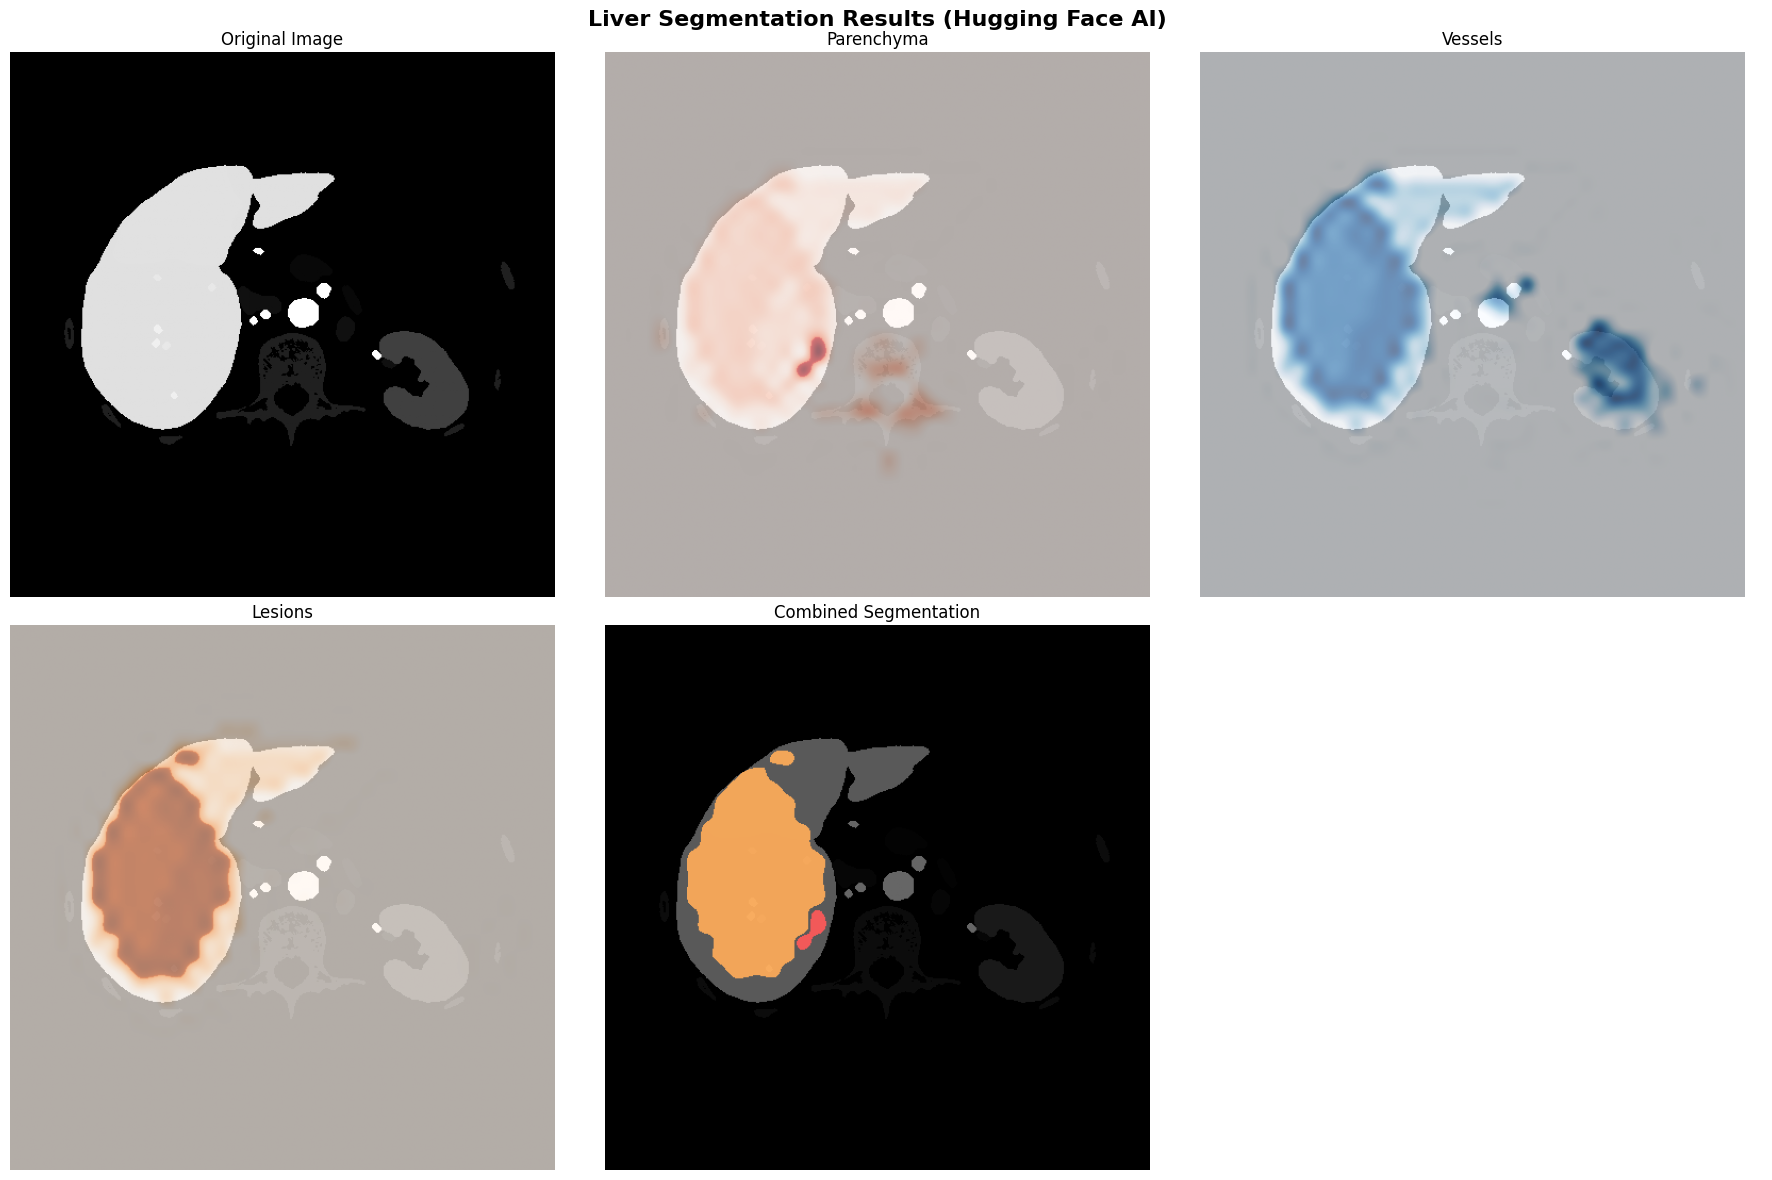


SEGMENTATION STATISTICS - LIVER
   Parenchyma:
     - Volume: 84.91 ml (163,334 voxels)
     - Percentage: 0.48%
   Vessels:
     - Volume: 0.00 ml (0 voxels)
     - Percentage: 0.00%
   Lesions:
     - Volume: 1588.57 ml (3,055,875 voxels)
     - Percentage: 9.04%

   Total segmented volume: 1673.47 ml
   Segmentation coverage: 13.07%


array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         ...,
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

        [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        

In [ ]:
reader.segment_organ_parts('liver', method='ai')

In [ ]:
reader.upload_nifti_file()

Select a NIFTI file (.nii or .nii.gz) to upload:


Saving LABELLED_DICOM_20090527125007_362662319.nii.gz to LABELLED_DICOM_20090527125007_362662319.nii.gz
Uploaded: LABELLED_DICOM_20090527125007_362662319.nii.gz
Loading NIFTI file: LABELLED_DICOM_20090527125007_362662319.nii.gz
NIFTI file loaded successfully!

NIFTI FILE ANALYSIS

Filename: LABELLED_DICOM_20090527125007_362662319.nii.gz
Data shape: (512, 512, 129)
Data type: float64
Voxel size: (np.float32(0.57), np.float32(0.57), np.float32(1.6)) mm
Memory usage: 258.00 MB


Loading Hugging Face model: nvidia/segformer-b0-finetuned-ade-512-512


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

Error loading Hugging Face model: Unrecognized configuration class <class 'transformers.models.segformer.configuration_segformer.SegformerConfig'> for this kind of AutoModel: AutoModelForImageSegmentation.
Model type should be one of DetrConfig.
Falling back to traditional segmentation methods

Starting brain segmentation using ai method...
Using Hugging Face AI segmentation for brain
Loading Hugging Face model: nvidia/segformer-b0-finetuned-ade-512-512


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Error loading Hugging Face model: Unrecognized configuration class <class 'transformers.models.segformer.configuration_segformer.SegformerConfig'> for this kind of AutoModel: AutoModelForImageSegmentation.
Model type should be one of DetrConfig.
Falling back to traditional segmentation methods
Using traditional segmentation methods for brain
   Downsampling large volume for faster processing...
   Reduced from (207, 256, 215) to (21, 26, 22)
   Applying intensity-based segmentation...
   Upsampling with enhanced smooth interpolation...
   Applying multi-stage smoothing for ultra-smooth results...
Segmentation completed successfully!


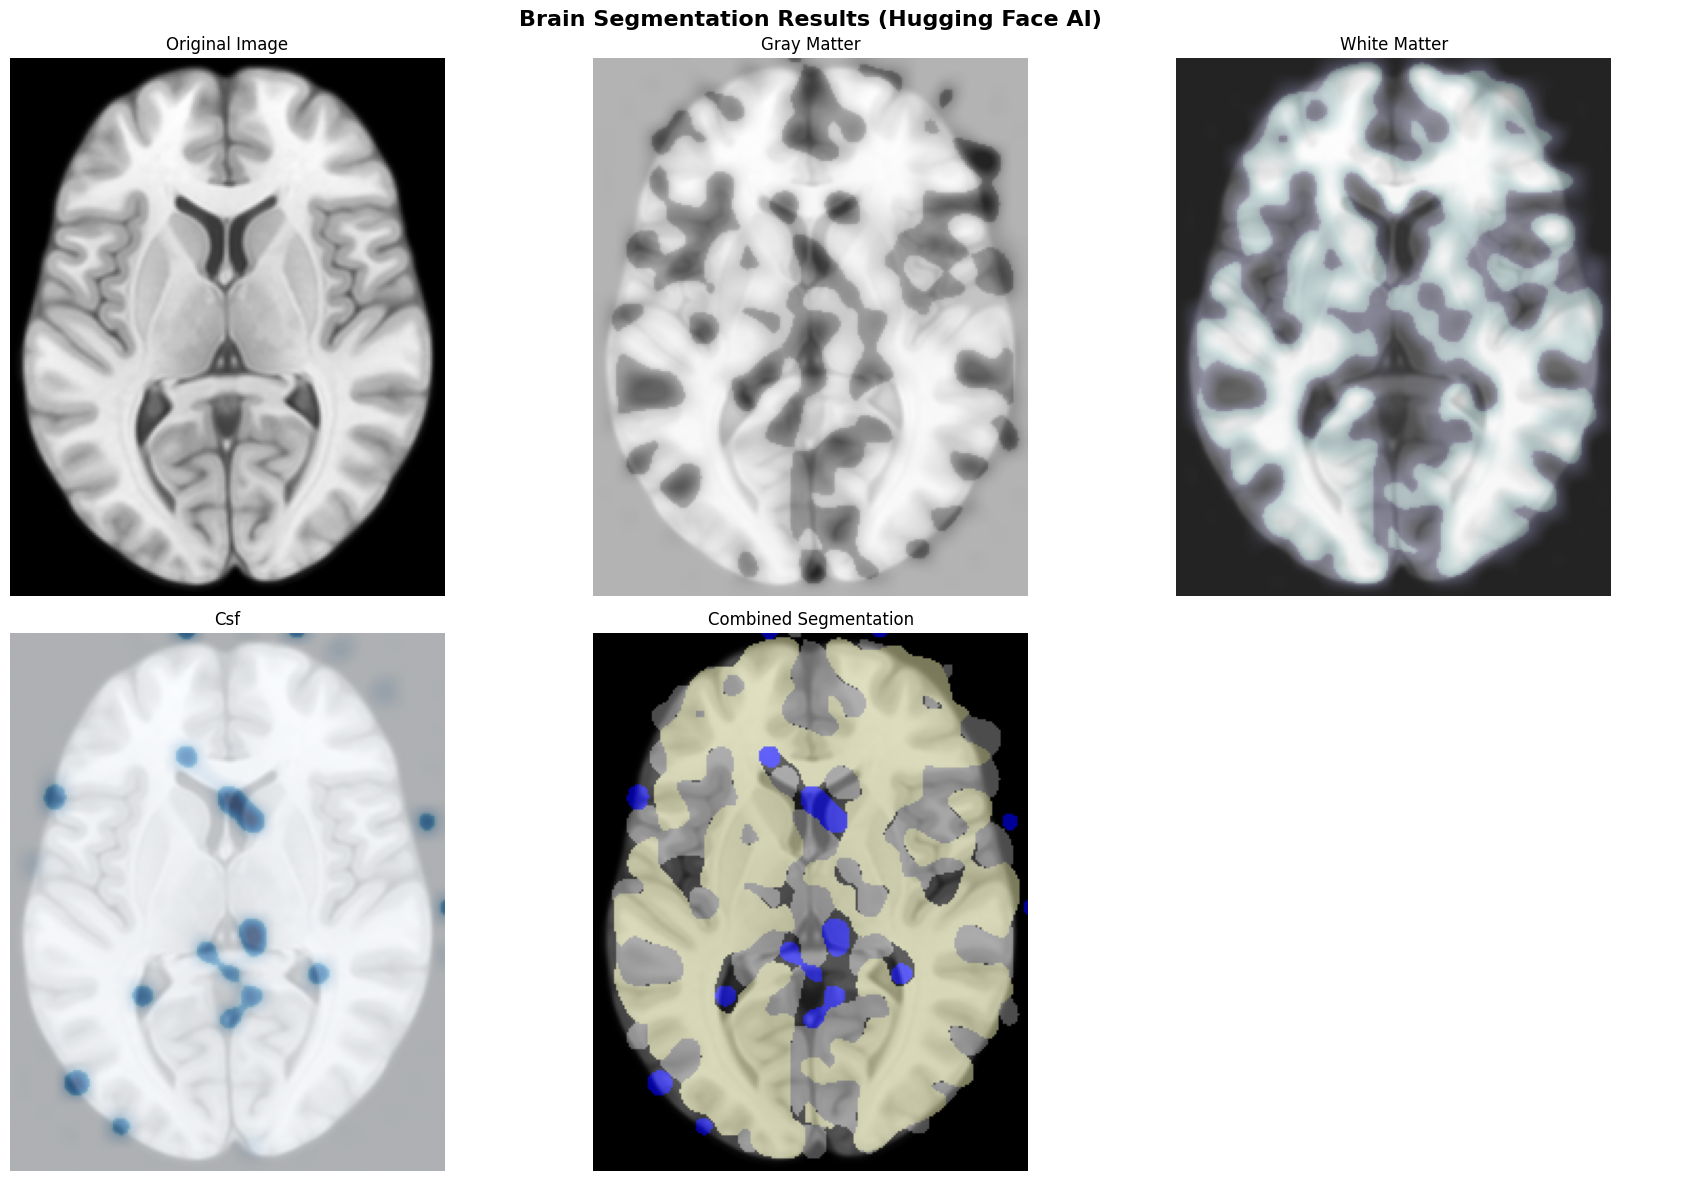


SEGMENTATION STATISTICS - BRAIN
   Gray Matter:
     - Volume: 701.30 ml (1,748,572 voxels)
     - Percentage: 15.35%
   White Matter:
     - Volume: 1239.36 ml (3,090,127 voxels)
     - Percentage: 27.12%
   Csf:
     - Volume: 80.57 ml (200,884 voxels)
     - Percentage: 1.76%

   Total segmented volume: 2021.23 ml
   Segmentation coverage: 47.51%


array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         ...,
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

        [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        

In [ ]:
reader.segment_organ_parts('brain', method='ai', hf_model='medical')

In [ ]:
reader.upload_nifti_file()

Select a NIFTI file (.nii or .nii.gz) to upload:


Saving mni152.nii.gz to mni152.nii.gz
Uploaded: mni152.nii.gz
Loading NIFTI file: mni152.nii.gz
NIFTI file loaded successfully!

NIFTI FILE ANALYSIS

Filename: mni152.nii.gz
Data shape: (207, 256, 215)
Data type: float64
Voxel size: (np.float32(0.7374631), np.float32(0.7374631), np.float32(0.7374631)) mm
Memory usage: 86.92 MB
